**Quanvolutional Neural Networks**

The Quantum Convolutional Neural Network is a quantum variational circuit whose classical counterpart is the Convolutional Neural Network. Quantum circuits can generate complex kernels computational classically unyielding.

**1) Data Preprocessing with Quantum Convolution**

1.   A kernel is traversing through a small region of the image and embedds the region into the circuit using an embedding method
2.   A unitary U in general generateed by variational quantum circuit is performed on the quantum system
3.  The quantum system is measured to obtain a list of classical expectation values where each expectation value is mapped to a different channel of a single output pixel. The expectation values can be classically further post-processed.

**2) Model training with Hybrid quantum-classical model**





In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 19.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
import os
os.makedirs("demonstration_assets/quanvolution/", exist_ok=True)

In [ ]:
#Set hyperparameter of the model
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
#Load MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
#******Quantum convolutional layer******
dev = qml.device("default.qubit", wires=4)
# Define random parameters for circuit
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):

    # Encoding of 4 classical input values
    # using Ry rotations (with angles scaled by a factor of π)
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit of n layers
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
#Convolutional scheeme:
'''
    The image is divided into squares of  2×2
    pixels where each square is embedded and processed by the quantum circuit.
    After measurement the 4 expectation values are mapped into
    different channels of a single output pixel.
'''

def quanv(image):
    # Stride of 2 is used thus output size is halfed
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
#If flag is set preprocess the train and test images
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


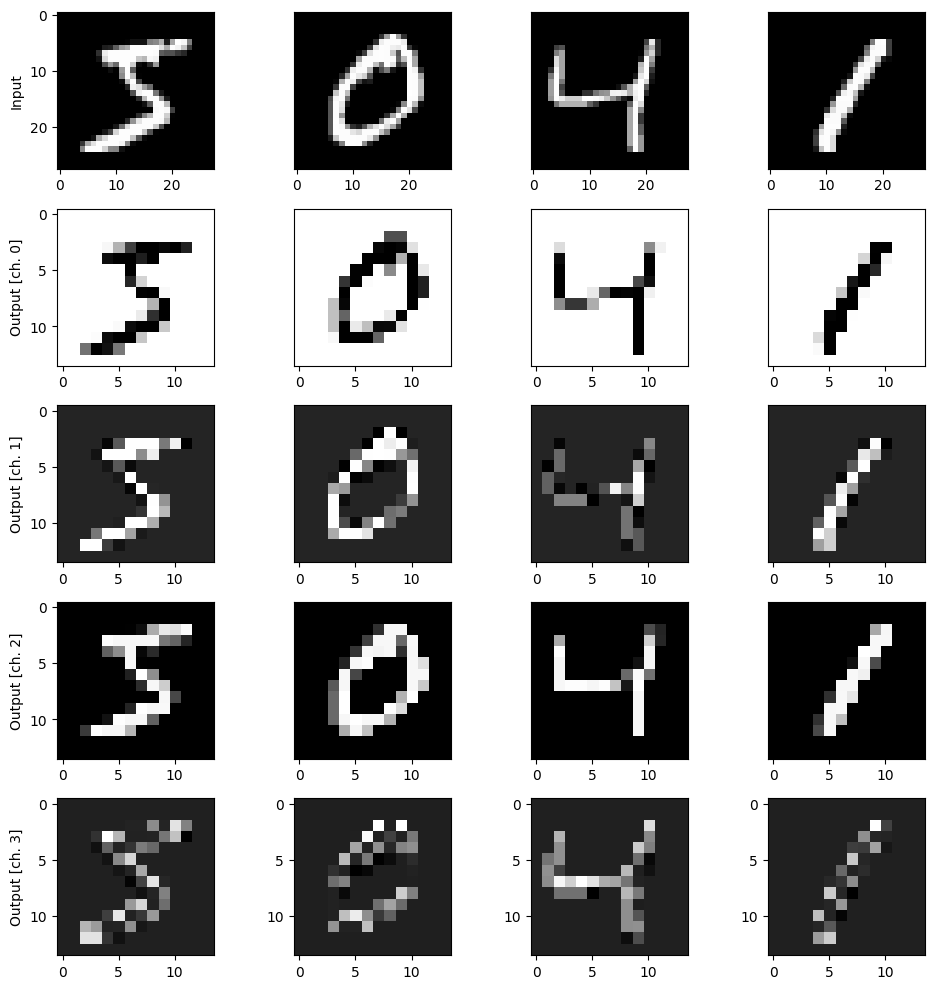

In [ ]:
#Visualize preproceessed images using 4 samples
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
#Define sequential model with one dense layer and outputlayer
# using softmax as activation function in the outputlayer sinve multiclass classification problem
# adam as optimization function
# sparse_categorical_crossentropy as loss function
# accuracy as metric
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
#Train the model with a batch size of 4
# and 30 epochs
#with preprocessed training and validation data
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.8428 - accuracy: 0.1600 - val_loss: 2.2151 - val_accuracy: 0.1667 - 749ms/epoch - 58ms/step
Epoch 2/30
13/13 - 0s - loss: 2.1393 - accuracy: 0.1800 - val_loss: 1.9439 - val_accuracy: 0.3000 - 68ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7563 - accuracy: 0.4400 - val_loss: 1.9145 - val_accuracy: 0.4000 - 88ms/epoch - 7ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3633 - accuracy: 0.6000 - val_loss: 1.6744 - val_accuracy: 0.4667 - 62ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1802 - accuracy: 0.7400 - val_loss: 1.5220 - val_accuracy: 0.5667 - 62ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9898 - accuracy: 0.8200 - val_loss: 1.5315 - val_accuracy: 0.5333 - 72ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7874 - accuracy: 0.8600 - val_loss: 1.4054 - val_accuracy: 0.6000 - 66ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6571 - accuracy: 0.9400 - val_loss: 1.3344 - val_accuracy: 0.6333 - 67ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

In [ ]:
#Train the model with a batch size of 4
# and 30 epochs
#WITHOUT preprocessed training and validation data
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4738 - accuracy: 0.0600 - val_loss: 2.3454 - val_accuracy: 0.1333 - 721ms/epoch - 55ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0620 - accuracy: 0.3200 - val_loss: 2.1465 - val_accuracy: 0.3000 - 65ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7306 - accuracy: 0.5600 - val_loss: 1.9830 - val_accuracy: 0.3667 - 71ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4884 - accuracy: 0.7200 - val_loss: 1.8346 - val_accuracy: 0.3667 - 69ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2724 - accuracy: 0.8000 - val_loss: 1.7041 - val_accuracy: 0.5000 - 60ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1041 - accuracy: 0.8600 - val_loss: 1.6054 - val_accuracy: 0.5333 - 72ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9609 - accuracy: 0.8600 - val_loss: 1.5350 - val_accuracy: 0.5667 - 83ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8436 - accuracy: 0.9000 - val_loss: 1.4637 - val_accuracy: 0.6333 - 71ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

<ipython-input-29-1015c6eb0cbe>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


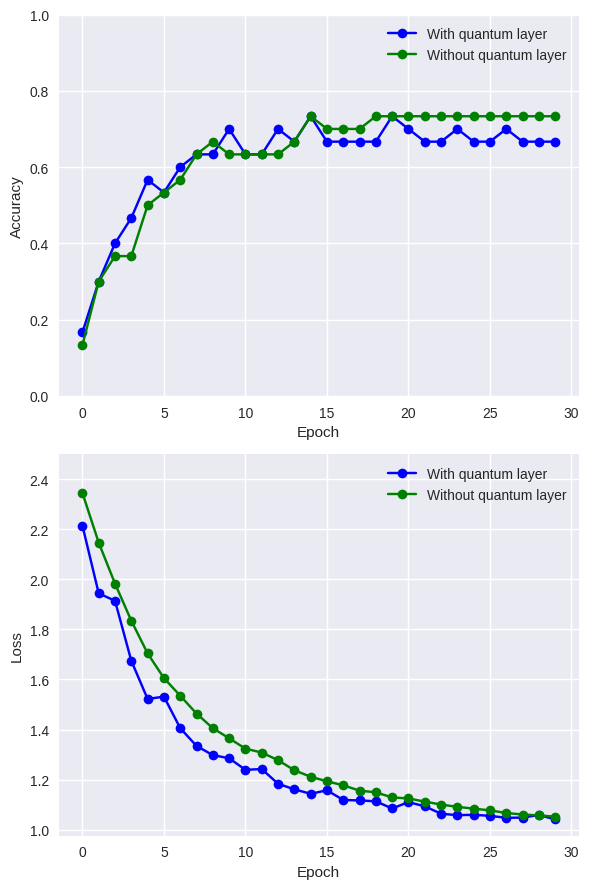

In [ ]:
#Plot the results
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()